In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import scipy.interpolate
%matplotlib inline
import seaborn as sns
import os

In [51]:
folder = '../'

In [52]:
potential = pd.read_csv(os.path.join(folder, 'potential000.xyz'),
                        sep=' ', names=['x', 'y', 'V'], header=0)
band = potential[potential.y==0.1][['x']].copy()
band['V'] = potential[potential.y==0.1].V * -1
band['V'] += np.abs(band.iloc[0].V)
band['x'] *= 1e3

band_inter = scipy.interpolate.interp1d(band.x, band.V, bounds_error=False, fill_value=0.)

In [53]:
efield = pd.read_csv(os.path.join(folder, 'x_Efield000.xyz'),
                     sep=' ', names=['x', 'y', 'F'], header=0)
efield = efield[efield.y==0.1][['x', 'F']]
efield['x'] *= 1e3

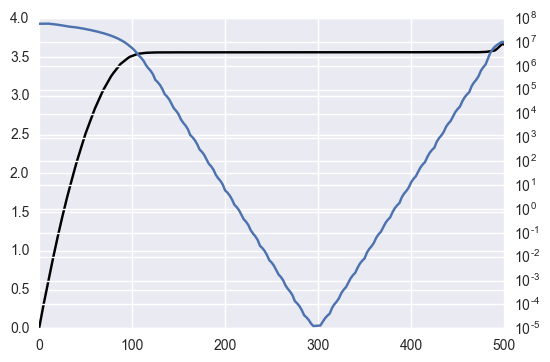

In [54]:
fig, ax = plt.subplots(1, 1)
ax2 = ax.twinx()
ax.plot(band.x, band.V, c='k')
ax2.semilogy(efield.x, efield.F)

In [55]:
valley_offset = np.zeros(10)
valley_offset[2] = 1.34
valley_offset[3] = 2.14

In [56]:
def read_tracking_data(filename):
    dt = np.dtype([('t', np.float32), ('x', np.float32), ('y', np.float32), ('E', np.float32), ('v', np.int32),])
    raw_data = np.fromfile(filename, dtype=dt)
    tr = pd.DataFrame(raw_data.tolist(), columns=raw_data.dtype.names)
    tr['t'] *= 1e12
    tr['x'] *= 1e9
    tr['y'] *= 1e9
    tr.loc[tr.v==9, 'v'] = 1
    tr['Eadj'] = tr.E + [valley_offset[v] for v in tr.v]
    tr['V'] = tr.Eadj + [band_inter(_) for _ in tr.x]
    return tr

In [57]:
def plot_xy_trajectory(data, cmap=None, ax=None):
    cmap = cmap or sns.dark_palette('purple', as_cmap=True)
    df = data[['x', 'y']]
    xy = df.as_matrix().reshape(-1, 1, 2)
    segments = np.hstack([xy[:-1], xy[1:]])

    coll = LineCollection(segments, cmap=cmap)
    coll.set_array(np.arange(0.0, 1.0, 1.0 / xy.shape[0]))

    if ax is None:
        fig, ax = plt.subplots()
    ax.add_collection(coll)
    ax.autoscale_view()
    ax.scatter(df['x'].iloc[[0, -1]].as_matrix(),
               df['y'].iloc[[0, -1]].as_matrix(),
               c=[0.0, 1.0], s=50, cmap=plt.cm.Greys, zorder=10)
    ax.set_xlim(0, max(50., df.x.max() * 1.1))
    ax.set_ylim(0, 200)

In [58]:
def plot_energy_band(data, cmap=None, ax=None, dots=False):
    cmap = cmap or plt.cm.coolwarm
    df = data[['x']].copy()
    df['V'] = data.Eadj + [band_inter(_) for _ in df.x]
    xy = df.as_matrix().reshape(-1, 1, 2)
    segments = np.hstack([xy[:-1], xy[1:]])

    coll = LineCollection(segments, cmap=cmap)
    coll.set_array(data.v - 1.0)

    if ax is None:
        fig, ax = plt.subplots()
    ax.axhline(3.18, c='k', ls='--', lw=1)
    band.plot(x='x', y='V', c='k', ax=ax, xlim=(0, max(50, df.x.max() * 1.1)), legend=False)
    ax.add_collection(coll)
    ax.autoscale_view()
    if dots:
        ax.scatter(df['x'], df['V'],
                   s=15, c='k', zorder=10)
    ax.scatter(df['x'].iloc[[0, -1]].as_matrix(),
               df['V'].iloc[[0, -1]].as_matrix(),
               c=[0.0, 1.0], s=50, cmap=cmap, zorder=10)

In [59]:
def times_scattered(data, Eth):
    all_times = data[data.V >= Eth].t.unique()
    if len(all_times) == 0:
        return 0
    times_scattered = all_times[np.array([len(data[data.t==t]) >= 2 for t in all_times])]
    return len(times_scattered)

In [80]:
sample = 7930
tr = read_tracking_data(os.path.join(folder, 'tracking{:06d}.bin'.format(sample)))

FileNotFoundError: [Errno 2] No such file or directory: '../tracking139000.bin'

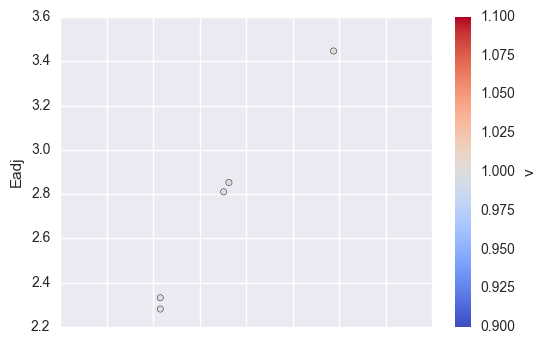

In [76]:
tr.plot(x='t', y='Eadj', kind='scatter', c='v', cmap='coolwarm')

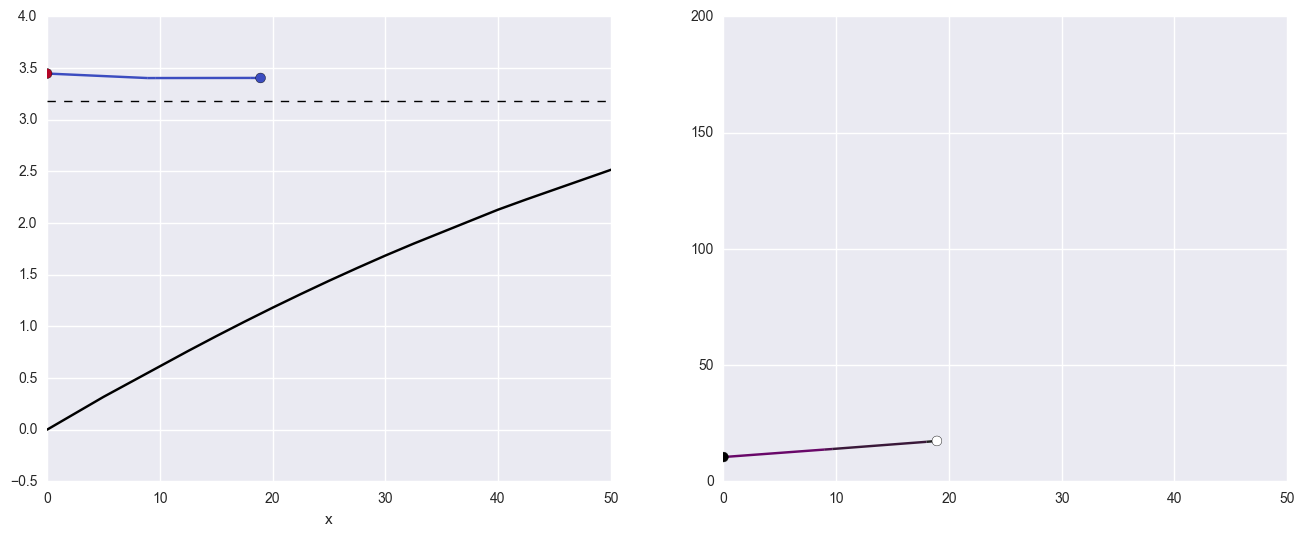

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_energy_band(tr, ax=ax[0])
plot_xy_trajectory(tr, ax=ax[1])

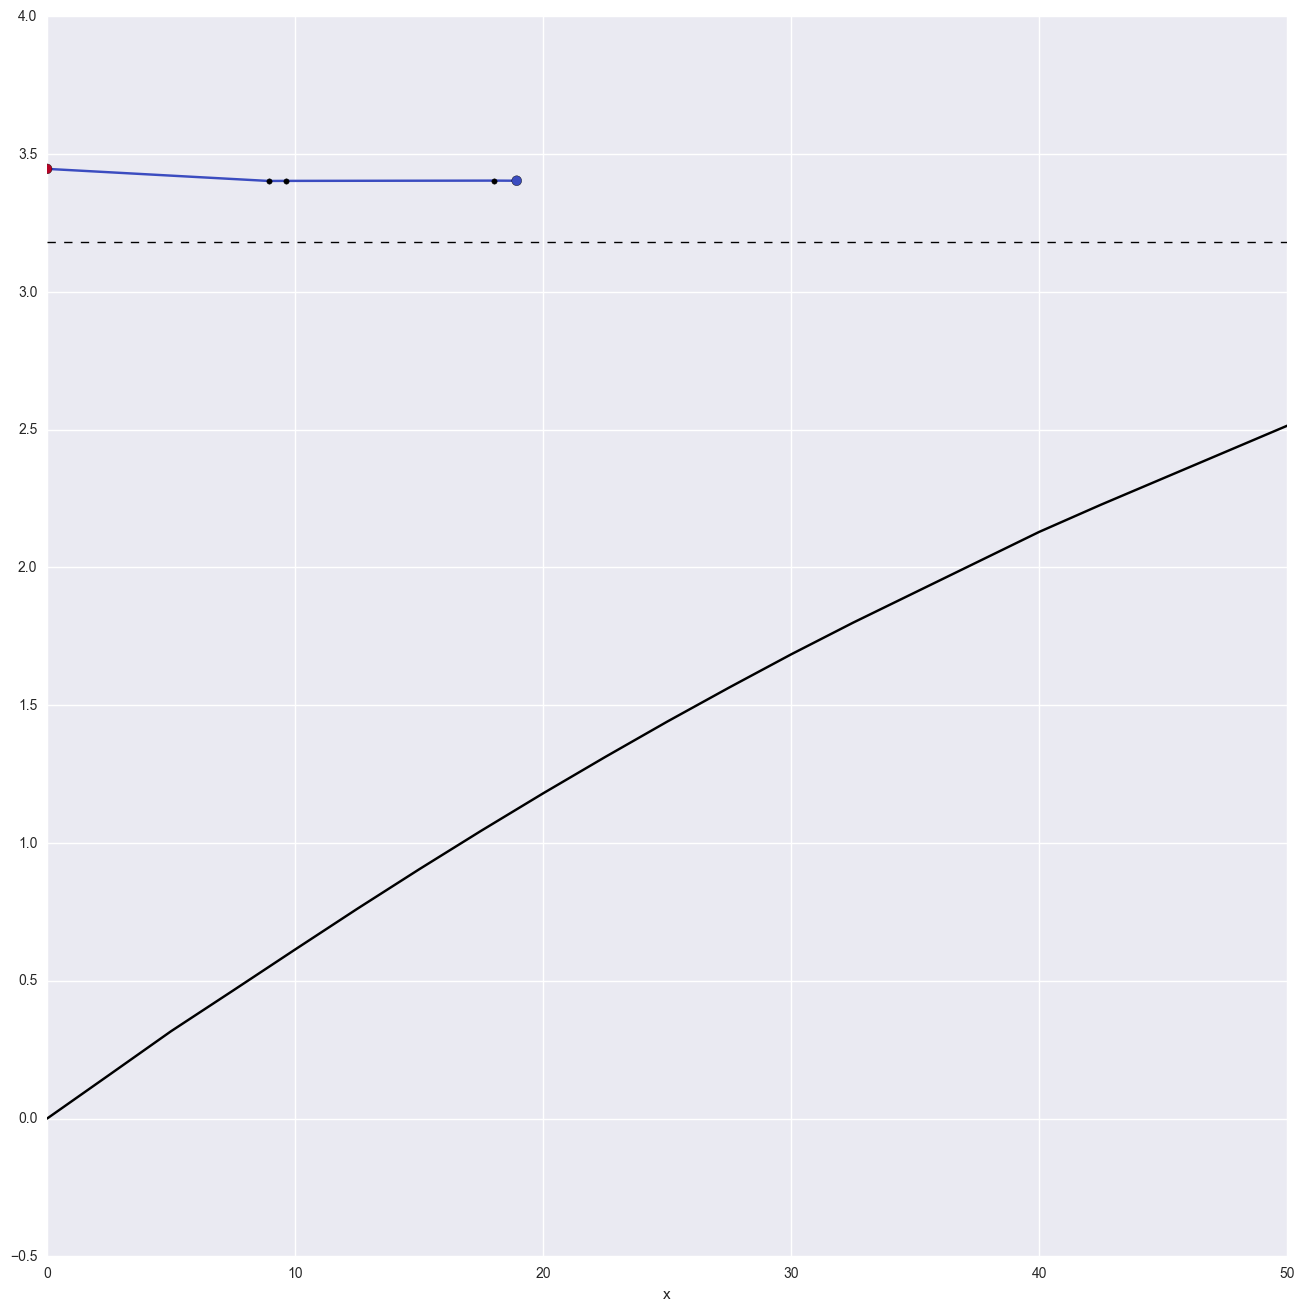

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
plot_energy_band(tr, ax=ax, dots=True)

In [79]:
tr.iloc[:50]

,t,x,y,E,v,Eadj,V
0,0.000779,18.935902,17.371807,2.281125,1,2.281125,3.403397
1,0.000779,18.009381,16.999653,2.331955,1,2.331955,3.403841
2,0.007593,9.648549,13.902031,2.810306,1,2.810306,3.402839
3,0.008162,8.933613,13.656833,2.852581,1,2.852581,3.402564
4,0.019414,0.000000,10.450350,3.446437,1,3.446437,3.446437


In [49]:
times_scattered(tr, 3.18)

3

In [250]:
positions = tr[tr.V >= 3.18].x.unique()

In [253]:
positions

array([ 69.97888136,  57.44313825,  58.00853131,  58.37697259,
        58.42352735,  58.68786701,  57.19737572,  57.09519257,
        53.00062966,  50.20142524,  49.08844531,  47.03572287,
        40.35515033,  39.9355109 ,  38.64479226,  38.33916296,
        38.27589268,  36.53126868,  35.21358849,  33.1132739 ,
        31.30896431,  26.22572559,  25.91093207,  25.91116299,
        24.5409808 ,  24.17633738,  25.03517926,  25.20451936,
        26.19991157,  26.2202029 ,  26.24311257,  26.22149253,
        24.20908096,  22.89856482,  23.50601669,  23.02037672,
        20.69090854,  16.42298386,  15.68623453,  15.53512341,
        14.5740513 ,  14.03554961,  12.17181822,   1.57970481,
         1.95904581,   1.99483163,   1.57345126,   2.17195173,
        10.34827957,  11.94778587,  12.9939135 ,  13.25297827,
        14.67036537,  15.91067011,  22.38903818,  22.59158371,
        22.65137233,  30.76852195,  31.2137729 ,  31.5290194 ,
        31.70728036,  30.86252676,  30.84755207,  30.17

In [254]:
differences = positions[:-1] - positions[1:]

In [259]:
differences.mean()
differences.std()

3.0242965307350969

In [257]:
scipy.stats.describe(differences)

DescribeResult(nobs=64, minmax=(-8.1763278370061698, 12.53574311022021), mean=0.62521576804641654, variance=9.2915499741626331, skewness=0.7624279870755307, kurtosis=5.700275921793951)